## Prove di altri grafi post colloquio col prof

In [5]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os
from IPython.display import display
import itertools
import plotly.graph_objects as go
import scipy
import re

df=pd.read_csv("nuovo_dataset.csv")
df["authors_list"] = df["Authors"].str.split(",")
df["authors_list"] = df["authors_list"].apply(
    lambda x: [a.strip() for a in x] if isinstance(x, list) else x
)

# assicura che Year sia numerico
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
grafi_per_anno = {}
for anno, df_anno in df.groupby("Year"):
    G = nx.Graph()
    for authors in df_anno["authors_list"].dropna():
        for a1, a2 in itertools.combinations(authors, 2):
            if G.has_edge(a1, a2):
                G[a1][a2]["weight"] += 1
            else:
                G.add_edge(a1, a2, weight=1)
    grafi_per_anno[anno] = G

Nodo più centrale: M.
Grado: 148
Betweenness: 0.362


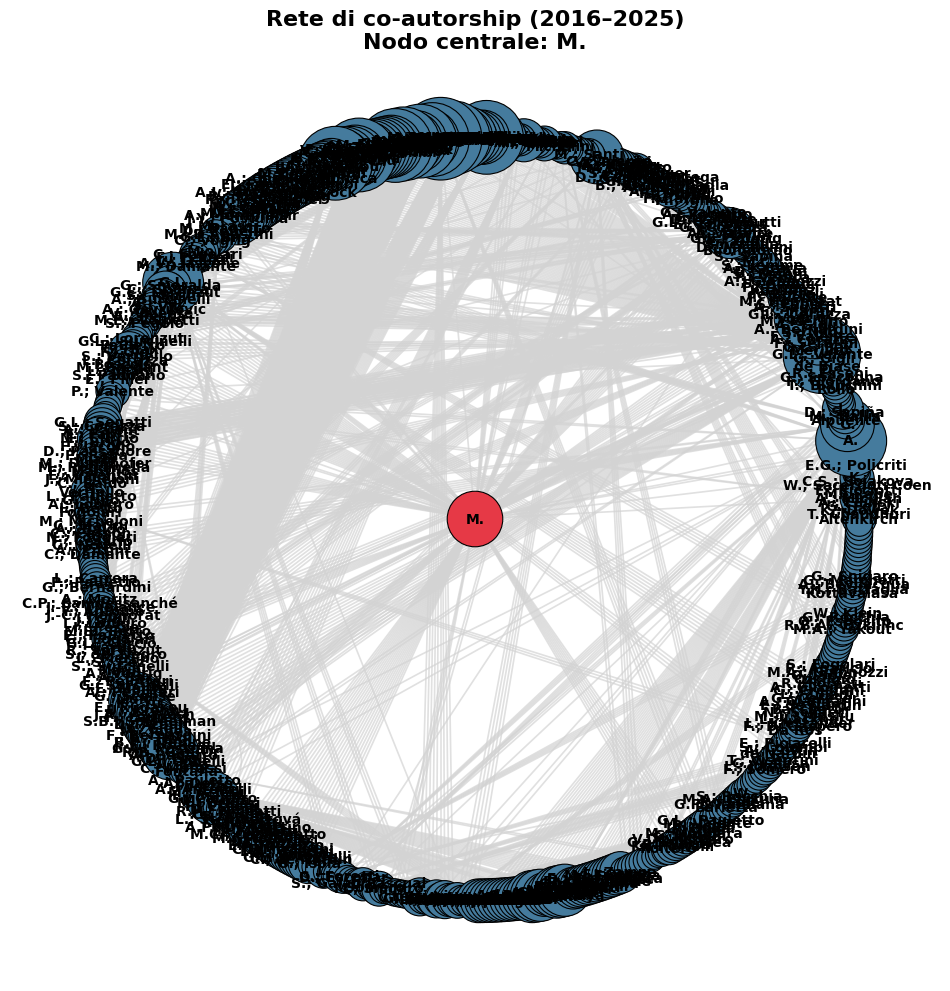

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# =========================
# 1️⃣ Grafo complessivo (2016–2025)
# =========================
G = nx.compose_all(grafi_per_anno.values())

# =========================
# 2️⃣ Calcolo delle centralità
# =========================
degree = dict(G.degree())
betweenness = nx.betweenness_centrality(G)

# nodo più centrale (grado massimo)
central_node = max(degree, key=degree.get)

print("Nodo più centrale:", central_node)
print("Grado:", degree[central_node])
print("Betweenness:", round(betweenness[central_node], 3))

# =========================
# 3️⃣ Layout circolare + nodo centrale al centro
# =========================
others = [n for n in G.nodes() if n != central_node]

# disposizione circolare per gli altri nodi
theta = np.linspace(0, 2*np.pi, len(others), endpoint=False)
radius = 3

pos = {central_node: (0, 0)}
for node, angle in zip(others, theta):
    pos[node] = (radius * np.cos(angle), radius * np.sin(angle))

# =========================
# 4️⃣ Colori e dimensioni
# =========================
node_colors = []
node_sizes = []

for n in G.nodes():
    if n == central_node:
        node_colors.append("#E63946")   # rosso acceso
        node_sizes.append(1600)         # molto grande
    else:
        node_colors.append("#457B9D")   # blu elegante
        node_sizes.append(300 + degree[n] * 30)

# =========================
# 5️⃣ Disegno del grafo (grafica figa)
# =========================
plt.figure(figsize=(12, 12))
plt.axis("off")

# archi
nx.draw_networkx_edges(
    G, pos,
    edge_color="lightgray",
    width=1.2,
    alpha=0.7
)

# nodi
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="black",
    linewidths=0.8
)

# etichette SOLO per i nodi più importanti
labels = {n: n for n in G.nodes() if degree[n] >= 5}
labels[central_node] = central_node

nx.draw_networkx_labels(
    G, pos,
    labels,
    font_size=10,
    font_weight="bold"
)

# =========================
# 6️⃣ Titolo finale
# =========================
plt.title(
    "Rete di co‑autorship (2016–2025)\n"
    f"Nodo centrale: {central_node}",
    fontsize=16,
    fontweight="bold"
)

plt.show()


# Autori e keyword
Analisis con vari layout e prove di filtro per centralità.

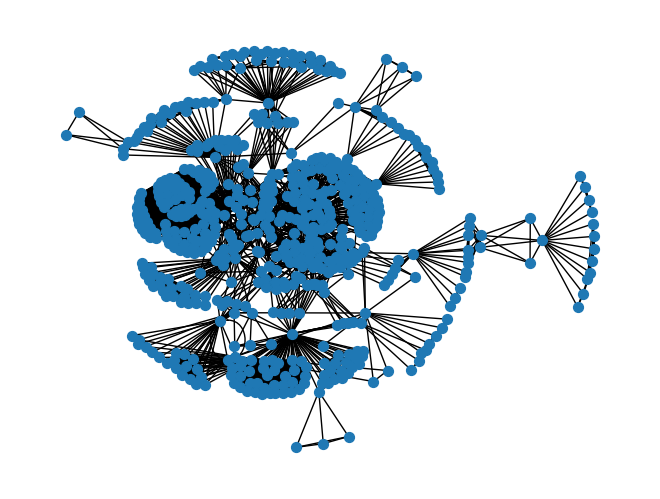

In [7]:

import re

def split_keywords(x):
    if pd.isna(x):
        return []
    return [k.strip() for k in re.split(r'[;,|]', x) if k.strip()]

df["author_kw_list"] = df["Author Keywords"].apply(split_keywords)
df["index_kw_list"] = df["Index Keywords"].apply(split_keywords)

df["all_keywords"] = df.apply(
    lambda row: list(set(row["author_kw_list"] + row["index_kw_list"])),
    axis=1
)

G_kw = nx.Graph()

for _, row in df.iterrows():
    article = row["Title"]
    keywords = row["all_keywords"]

    for kw in keywords:
        G_kw.add_node(article, type="article")
        G_kw.add_node(kw, type="keyword")
        G_kw.add_edge(article, kw)

G_prof_kw = nx.Graph()

for _, row in df.iterrows():
    authors = row["authors_list"]
    keywords = row["all_keywords"]

    if not isinstance(authors, list):
        continue

    for a in authors:
        for kw in keywords:
            G_prof_kw.add_node(a, type="author")
            G_prof_kw.add_node(kw, type="keyword")
            G_prof_kw.add_edge(a, kw)

def filter_by_centrality(G, threshold=0.03):
    centrality = nx.degree_centrality(G)
    nodes_to_keep = [n for n, c in centrality.items() if c >= threshold]
    return G.subgraph(nodes_to_keep).copy(), centrality


def draw_kamada(G, centrality, title):
    pos = nx.kamada_kawai_layout(G)

    sizes = [centrality[n] * 2000 for n in G.nodes()]
    colors = [
        "gold" if G.nodes[n]["type"]=="article" else
        "skyblue" if G.nodes[n]["type"]=="author" else
        "purple"
        for n in G.nodes()
    ]

    plt.figure(figsize=(16,14))
    nx.draw(
        G, pos,
        node_size=sizes,
        node_color=colors,
        with_labels=False,
        alpha=0.85
    )

    labels = {
        n: n for n in G.nodes()
        if centrality[n] >= sorted(centrality.values())[-10]  # top 10
    }

    nx.draw_networkx_labels(G, pos, labels, font_size=9)
    plt.title(title)
    plt.show()

pos = nx.kamada_kawai_layout(G, weight=None)
nx.draw(G, pos, node_size=50, with_labels=False)
plt.show()


=== Layout: spring ===


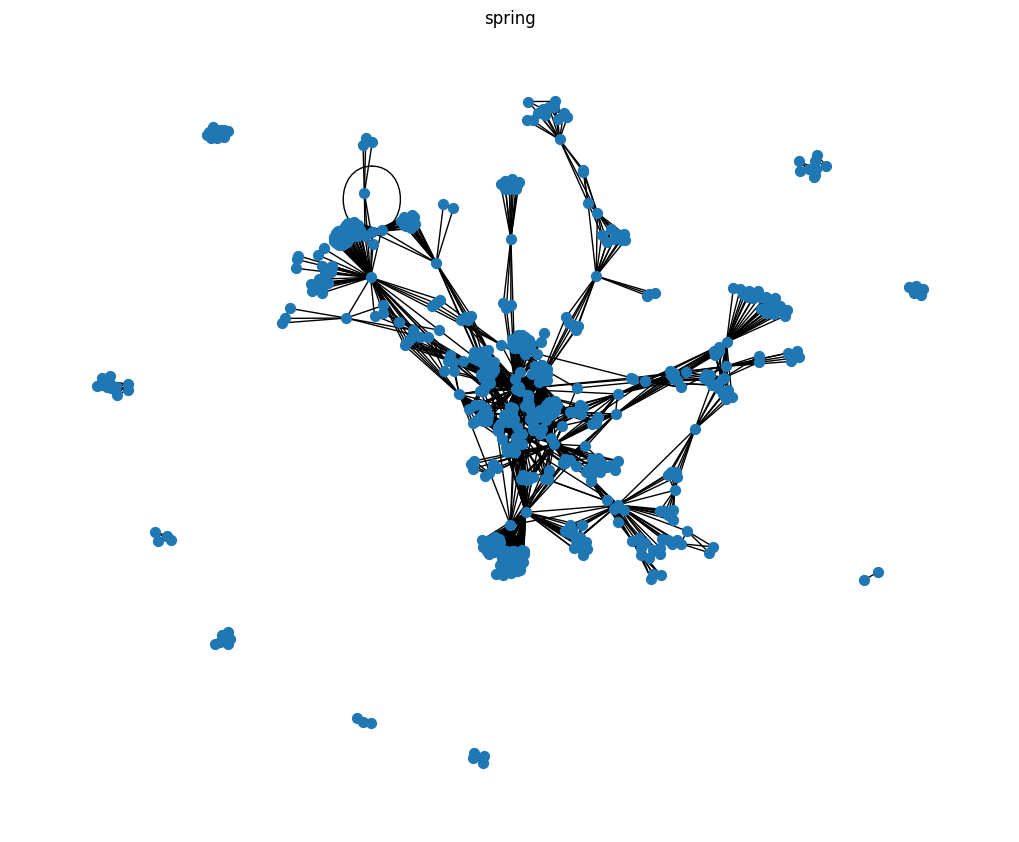


=== Layout: kamada_kawai ===


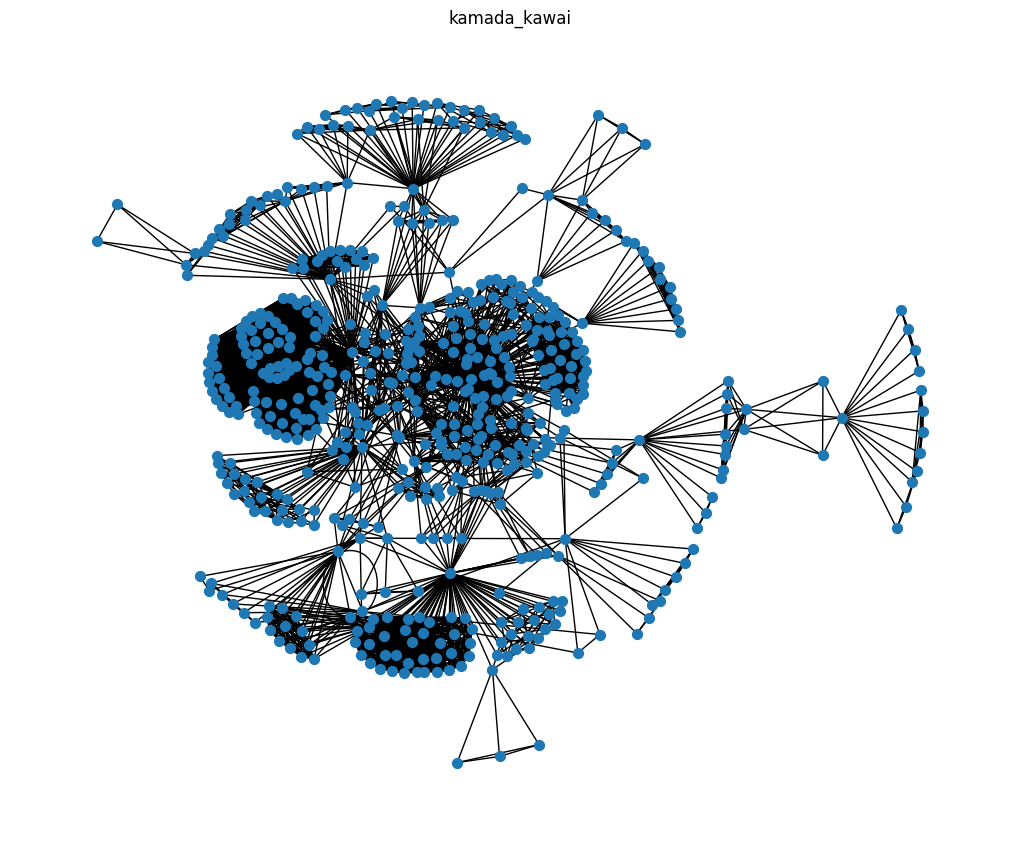


=== Layout: circular ===


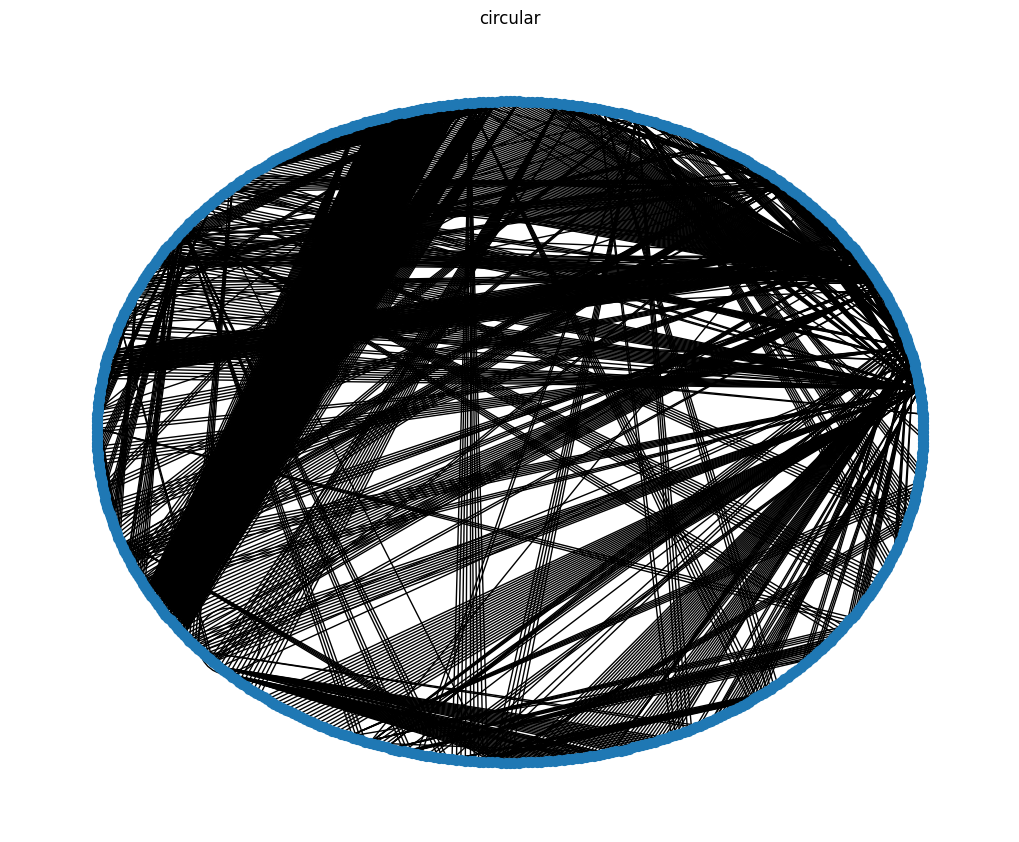


=== Layout: shell ===
Errore nel layout shell: name 'articles' is not defined

=== Layout: spectral ===


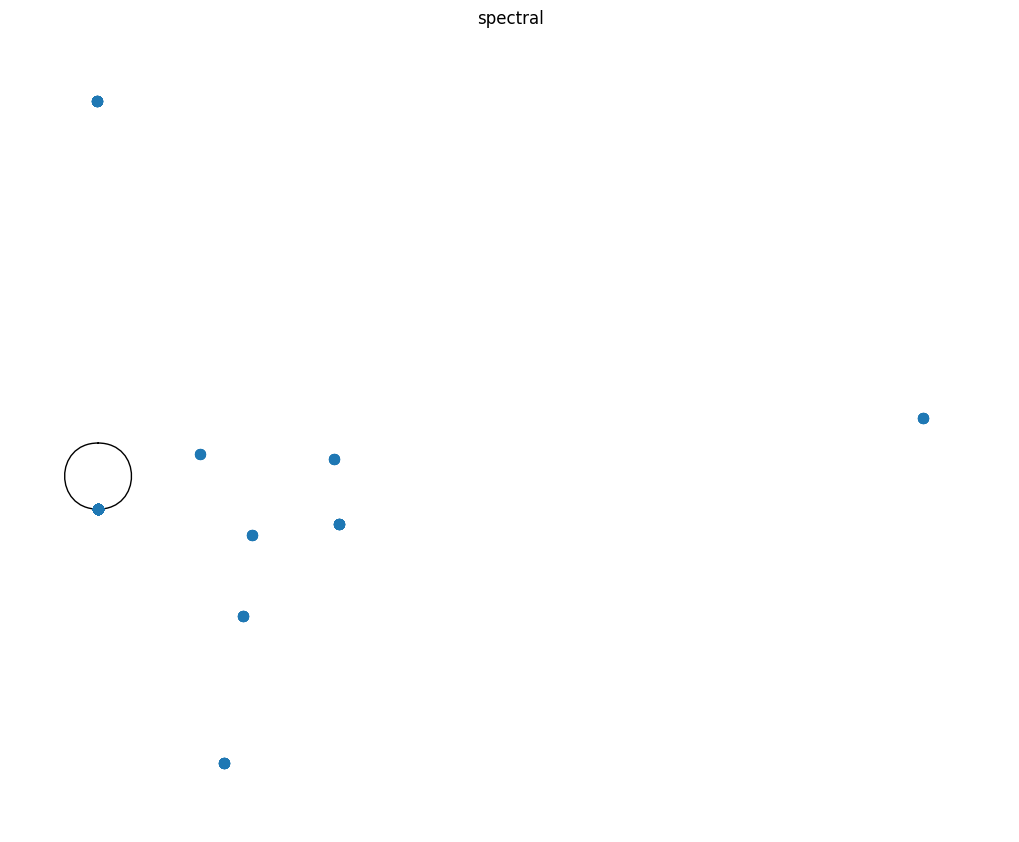


=== Layout: spiral ===


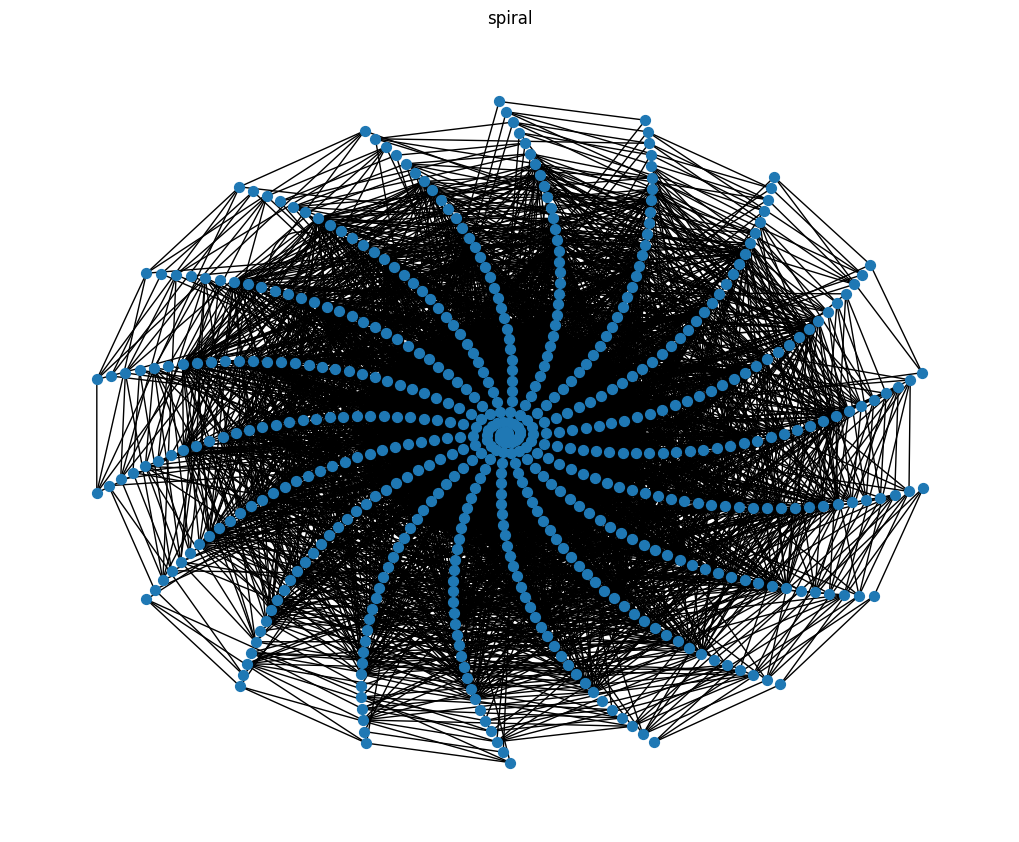

In [26]:
layouts = {
    "spring": nx.spring_layout,
    "kamada_kawai": nx.kamada_kawai_layout,
    "circular": nx.circular_layout,
    "shell": lambda G: nx.shell_layout(G, nlist=[keywords, articles]),
    "spectral": nx.spectral_layout,
    "spiral": nx.spiral_layout
}

for name, layout in layouts.items():
    try:
        print(f"\n=== Layout: {name} ===")
        pos = layout(G)
        plt.figure(figsize=(10,8))
        nx.draw(G, pos, node_size=50, with_labels=False)
        plt.title(name)
        plt.show()
    except Exception as e:
        print(f"Errore nel layout {name}: {e}")

In [31]:
import re

def split_keywords(x):
    if pd.isna(x):
        return []
    return [k.strip() for k in re.split(r'[;,|]', x) if k.strip()]

df["author_kw_list"] = df["Author Keywords"].apply(split_keywords)
df["index_kw_list"] = df["Index Keywords"].apply(split_keywords)

df["all_keywords"] = df.apply(
    lambda row: list(set(row["author_kw_list"] + row["index_kw_list"])),
    axis=1
)

In [33]:
G_kw = nx.Graph()

for _, row in df.iterrows():
    article = row["Title"]
    keywords = row["all_keywords"]

    for kw in keywords:
        G_kw.add_node(article, type="article")
        G_kw.add_node(kw, type="keyword")
        G_kw.add_edge(article, kw)

In [65]:
t=0.01
def filter_by_centrality(G, threshold=t):
    cent = nx.degree_centrality(G)
    nodes_to_keep = [n for n, c in cent.items() if c >= threshold]
    return G.subgraph(nodes_to_keep).copy(), cent

G_kw_filt, cent_kw = filter_by_centrality(G_kw, threshold=t) #REGOLARE

In [61]:
def compute_layout(G, layout="kamada"):
    if layout == "spring":
        return nx.spring_layout(G, seed=42, k=0.8, iterations=200)

    elif layout == "kamada":
        return nx.kamada_kawai_layout(G)

    elif layout == "circular":
        return nx.circular_layout(G)

    elif layout == "spectral":
        try:
            return nx.spectral_layout(G)
        except:
            return nx.spring_layout(G)

    elif layout == "shell":
        keywords = [n for n in G.nodes() if G.nodes[n]["type"]=="keyword"]
        articles = [n for n in G.nodes() if G.nodes[n]["type"]=="article"]
        if len(keywords) > 0 and len(articles) > 0:
            return nx.shell_layout(G, nlist=[keywords, articles])
        else:
            return nx.spring_layout(G)

    else:
        return nx.spring_layout(G)

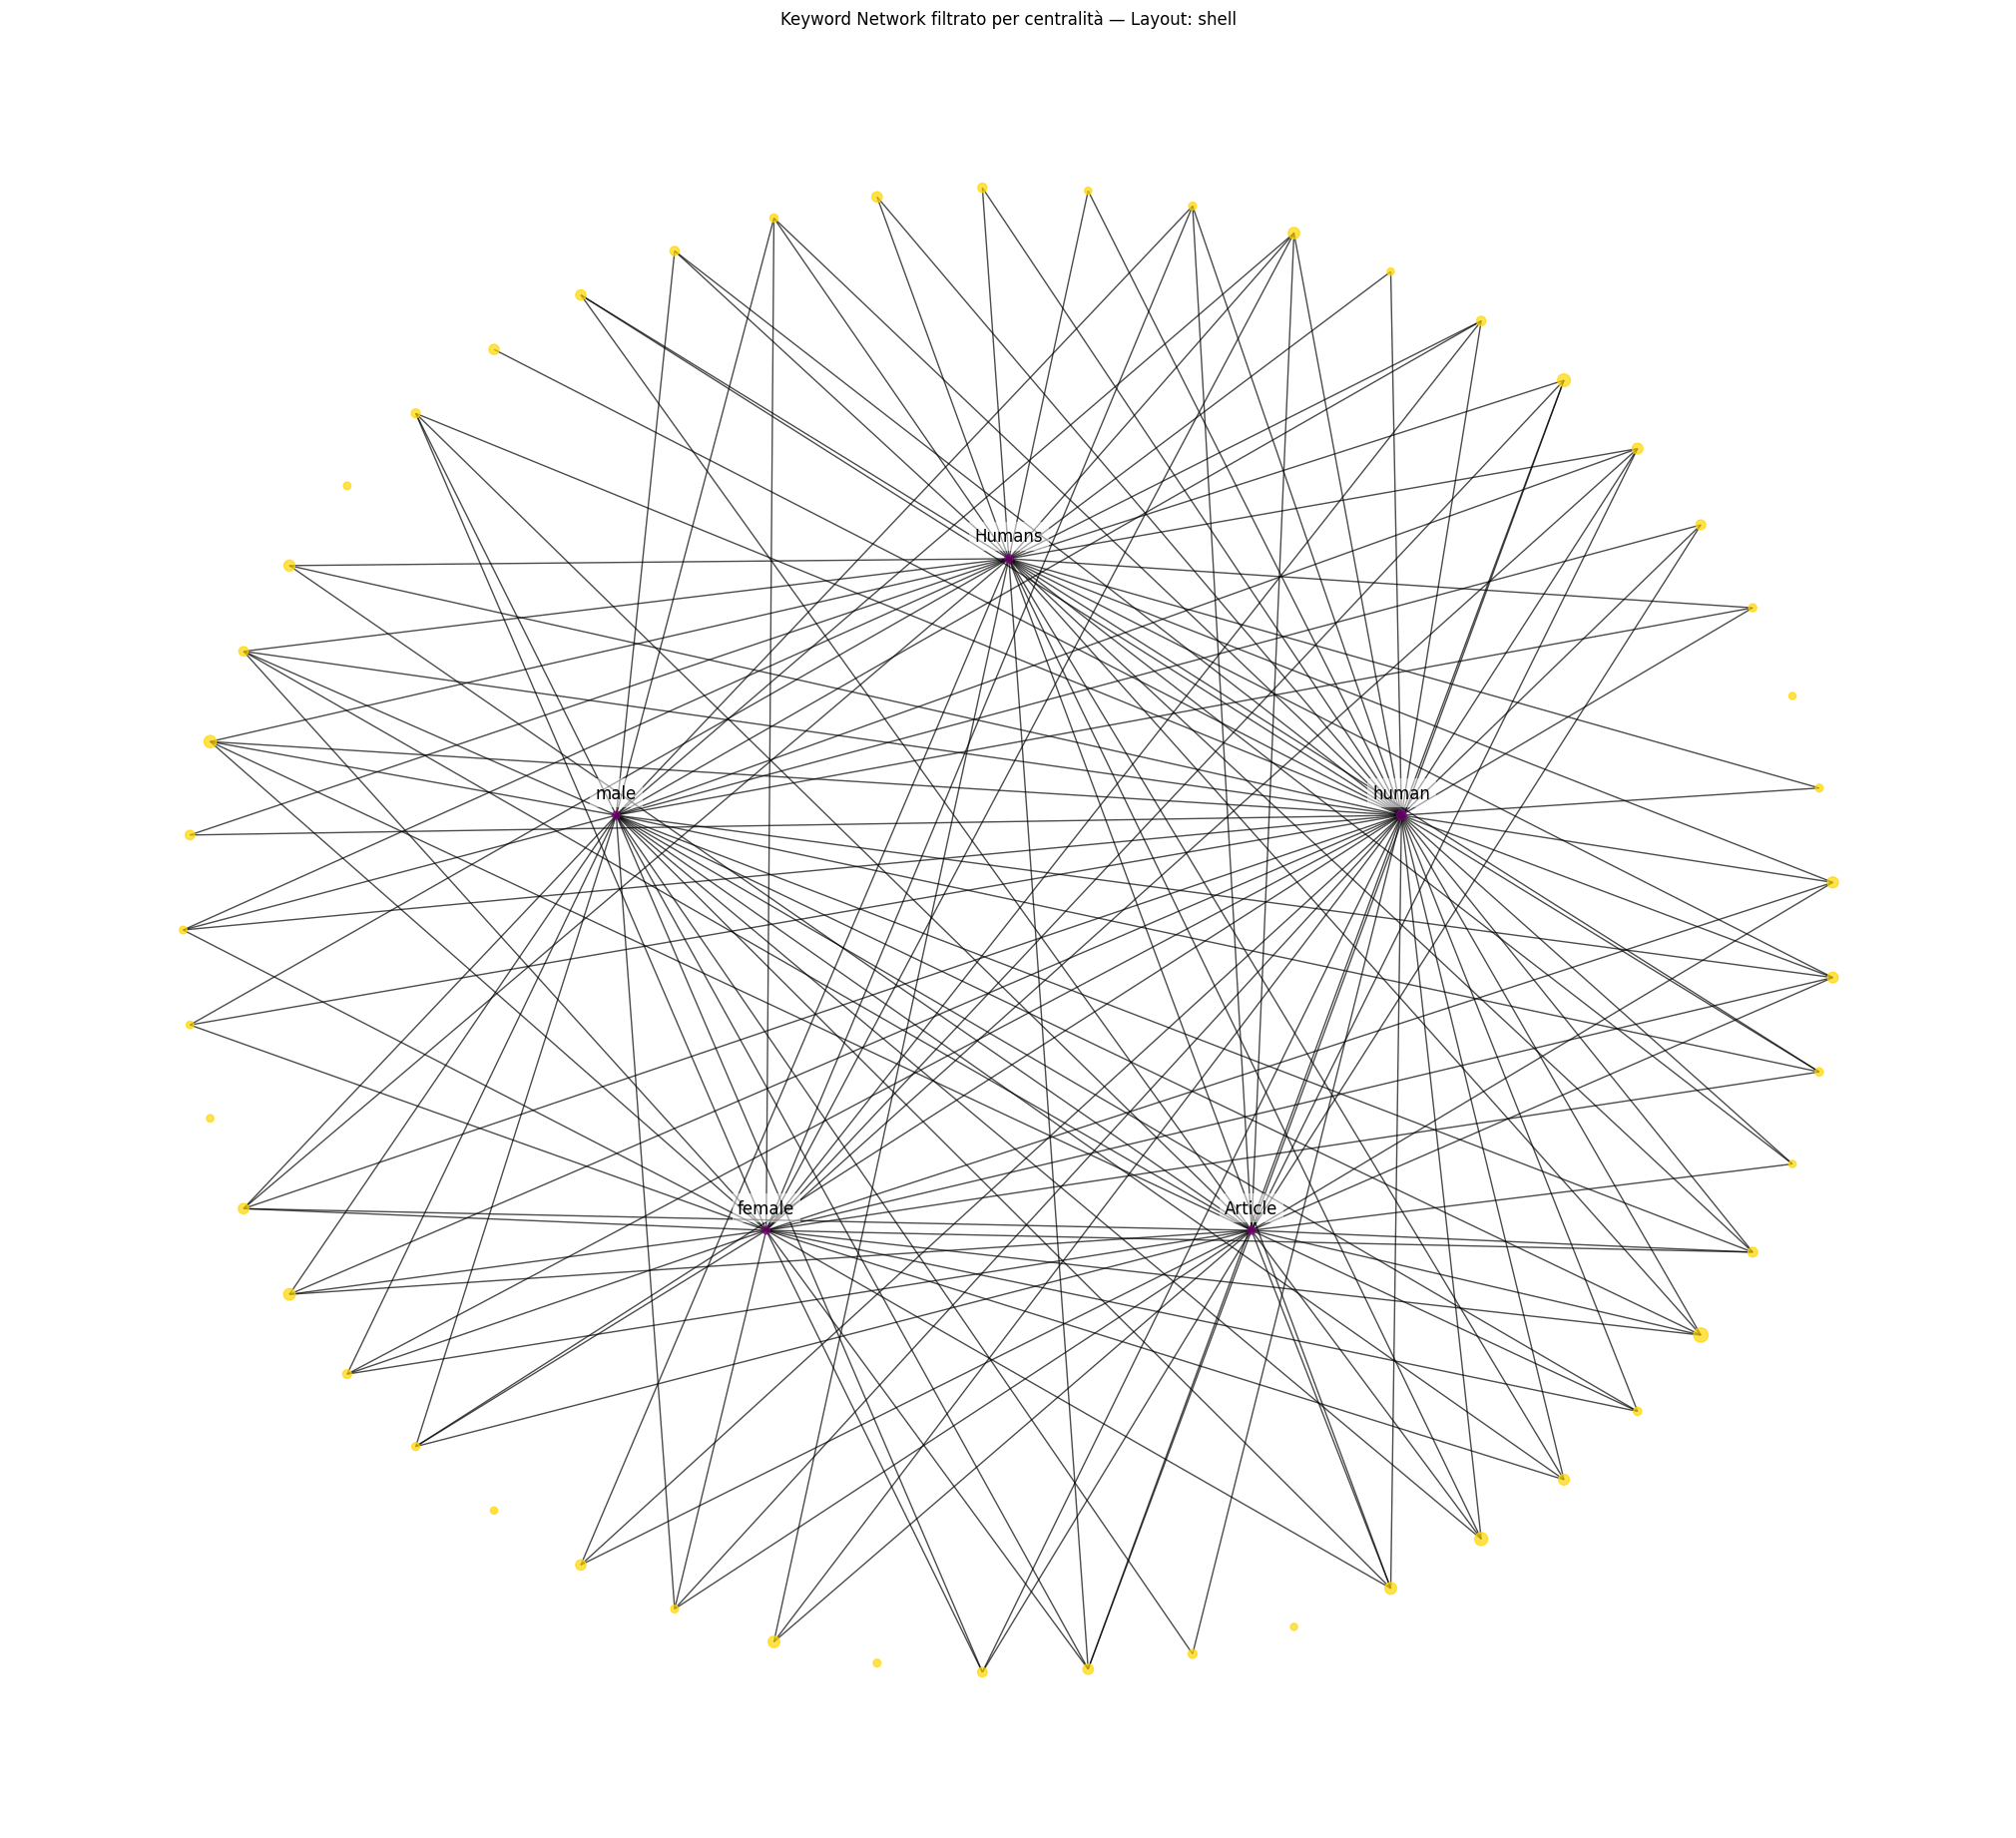

In [66]:
LAYOUT = "shell"
pos_kw = compute_layout(G_kw_filt, layout=LAYOUT)

plt.figure(figsize=(20,18))

sizes = [cent_kw[n] * 2500 for n in G_kw_filt.nodes()]
colors = [
    "gold" if G_kw_filt.nodes[n]["type"]=="article" else "purple"
    for n in G_kw_filt.nodes()
]

nx.draw(
    G_kw_filt, pos_kw,
    node_size=sizes,
    node_color=colors,
    with_labels=False,
    alpha=0.7
)

# Etichette keyword importanti
labels = {
    n: n for n in G_kw_filt.nodes()
    if G_kw_filt.nodes[n]["type"]=="keyword" and cent_kw[n] >= t
}

# Spostamento leggero verso l’alto
offset_pos = {n: (x, y+0.03) for n, (x, y) in pos_kw.items()}

nx.draw_networkx_labels(
    G_kw_filt, offset_pos, labels,
    font_size=12,
    font_color="black",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.5)
)

plt.title(f"Keyword Network filtrato per centralità — Layout: {LAYOUT}")
plt.show()

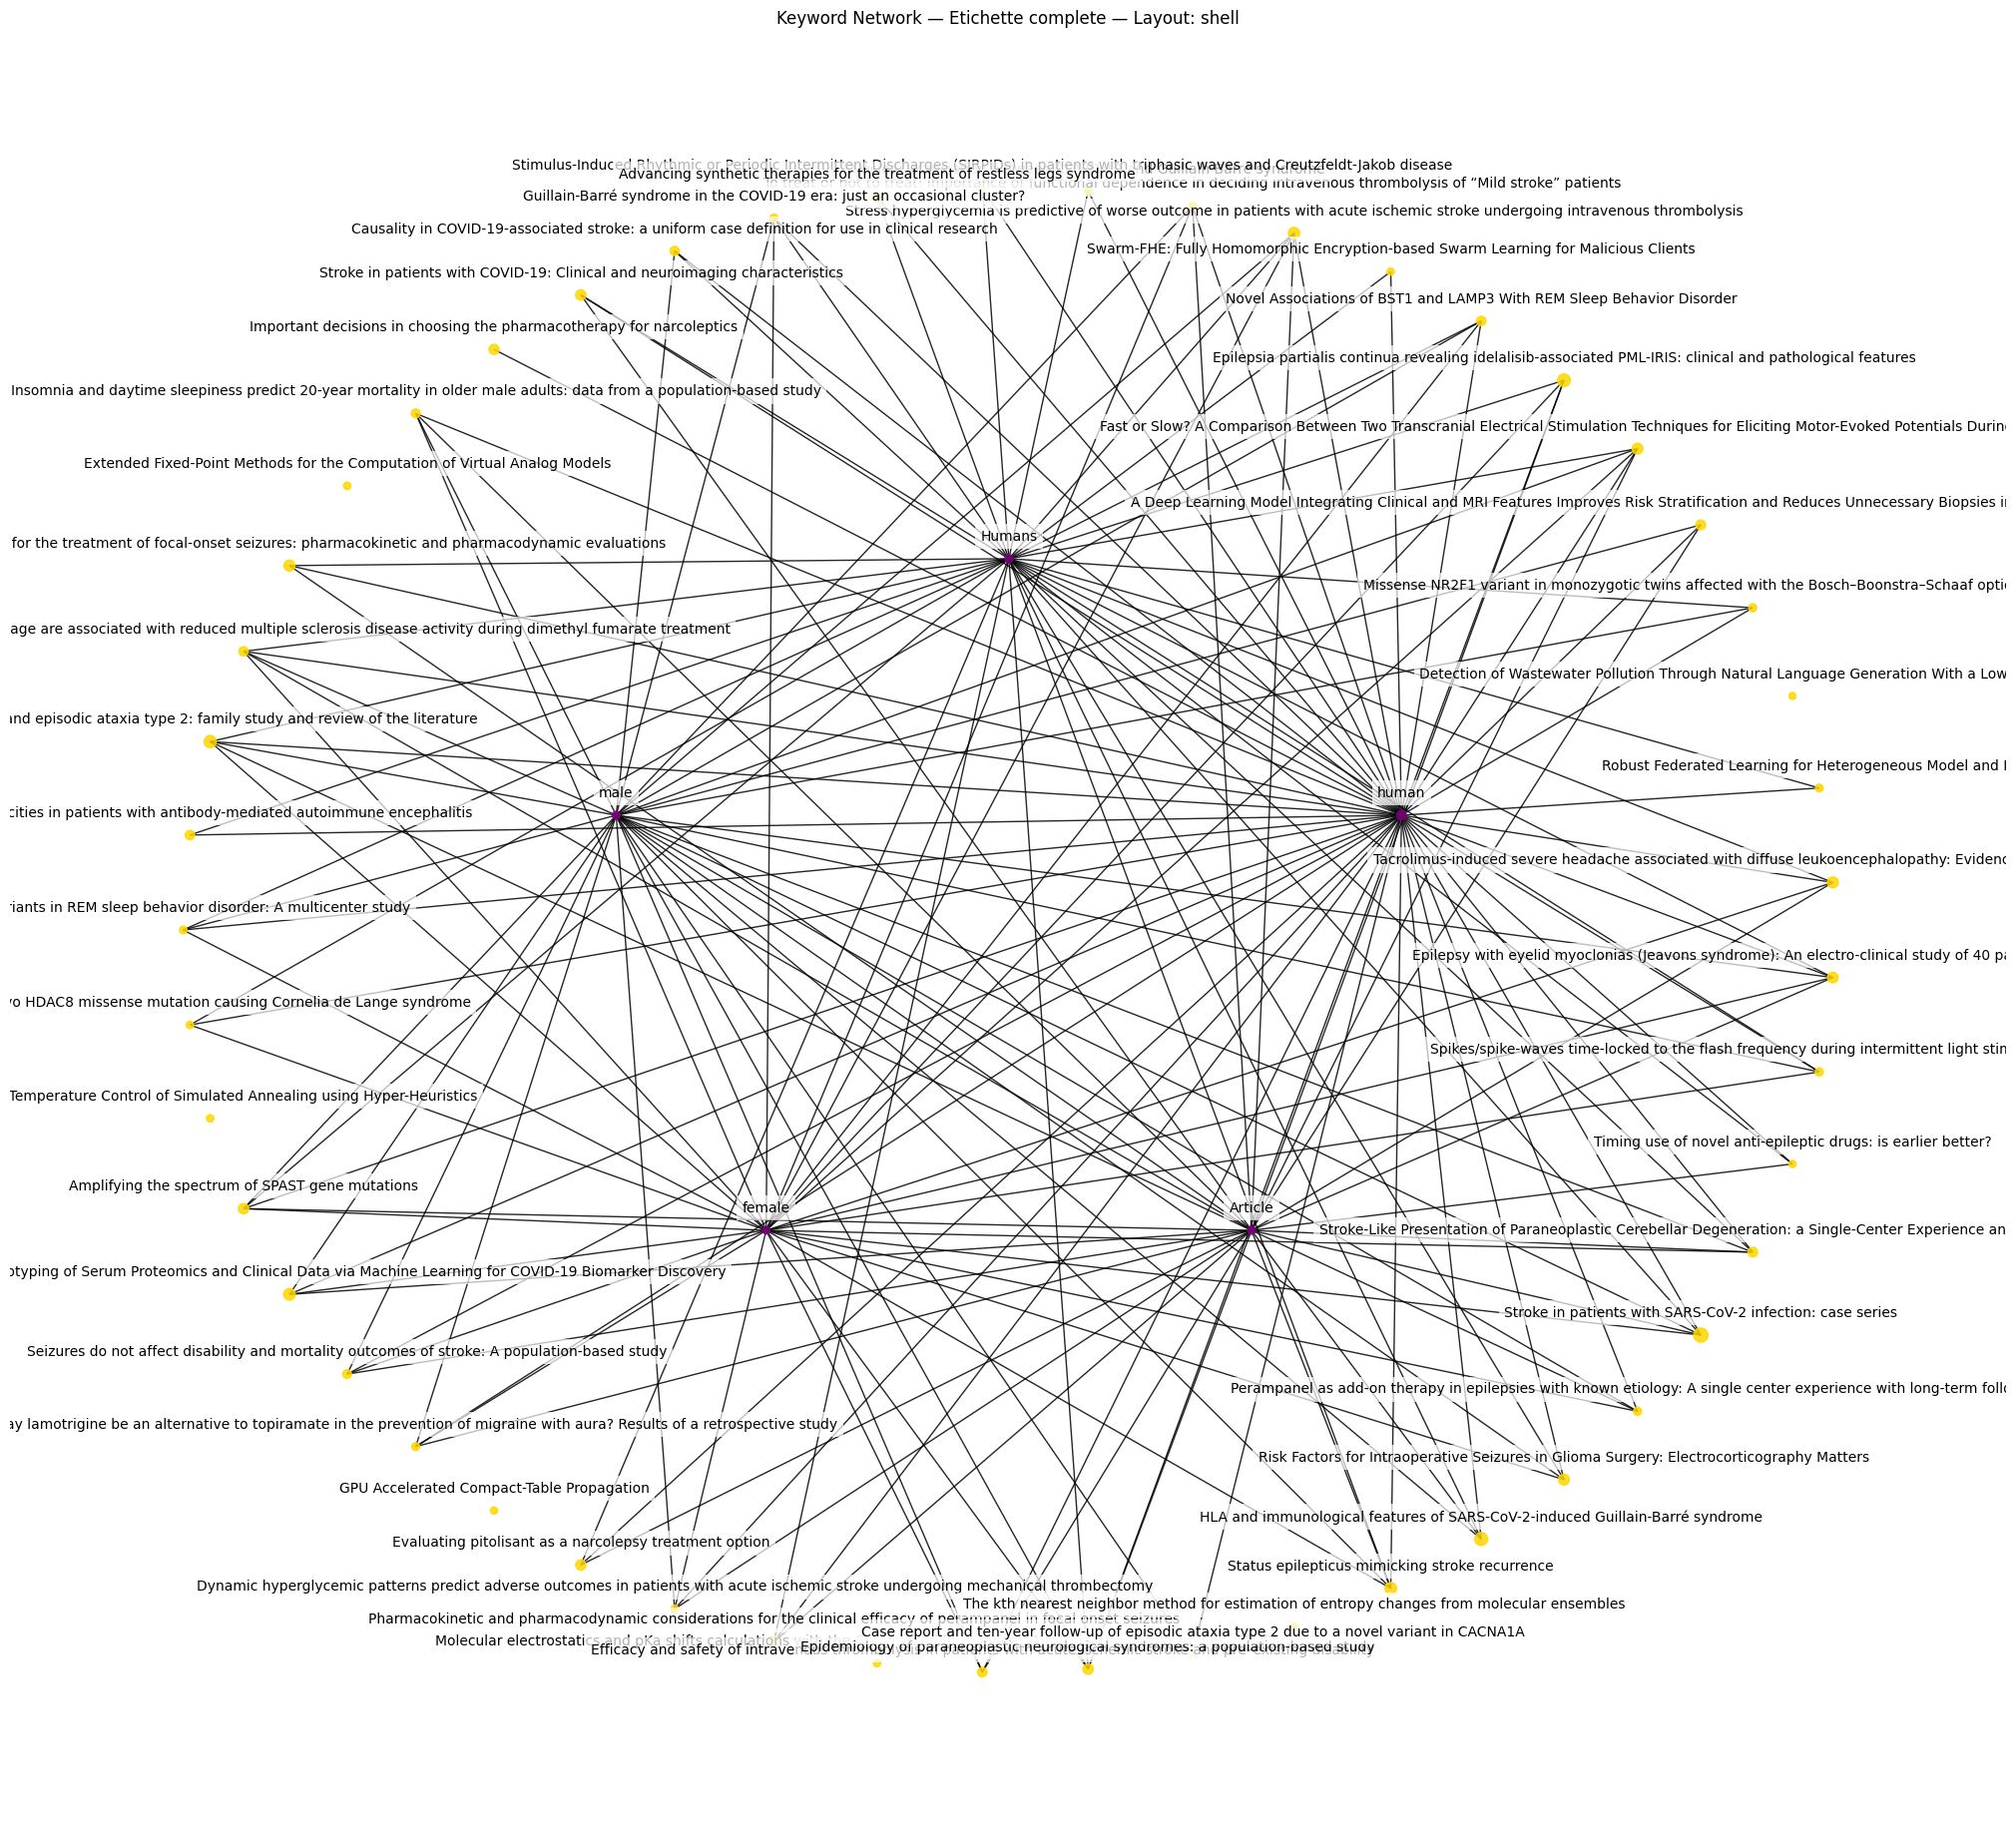

In [ ]:
LAYOUT = "shell"
pos_kw = compute_layout(G_kw_filt, layout=LAYOUT)

plt.figure(figsize=(20,18))

sizes = [cent_kw[n] * 2500 for n in G_kw_filt.nodes()]
colors = [
    "gold" if G_kw_filt.nodes[n]["type"]=="article" else "purple"
    for n in G_kw_filt.nodes()
]

nx.draw(
    G_kw_filt, pos_kw,
    node_size=sizes,
    node_color=colors,
    with_labels=False,
    alpha=0.85
)

# Etichette per TUTTI i nodi
labels_all = {n: n for n in G_kw_filt.nodes()}

# Spostamento leggero verso l’alto per evitare sovrapposizione con il nodo
offset_pos = {n: (x, y+0.03) for n, (x, y) in pos_kw.items()}

nx.draw_networkx_labels(
    G_kw_filt, offset_pos, labels_all,
    font_size=10,
    font_color="black",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)
)

plt.title(f"Keyword Network — Etichette complete — Layout: {LAYOUT}")
plt.show()

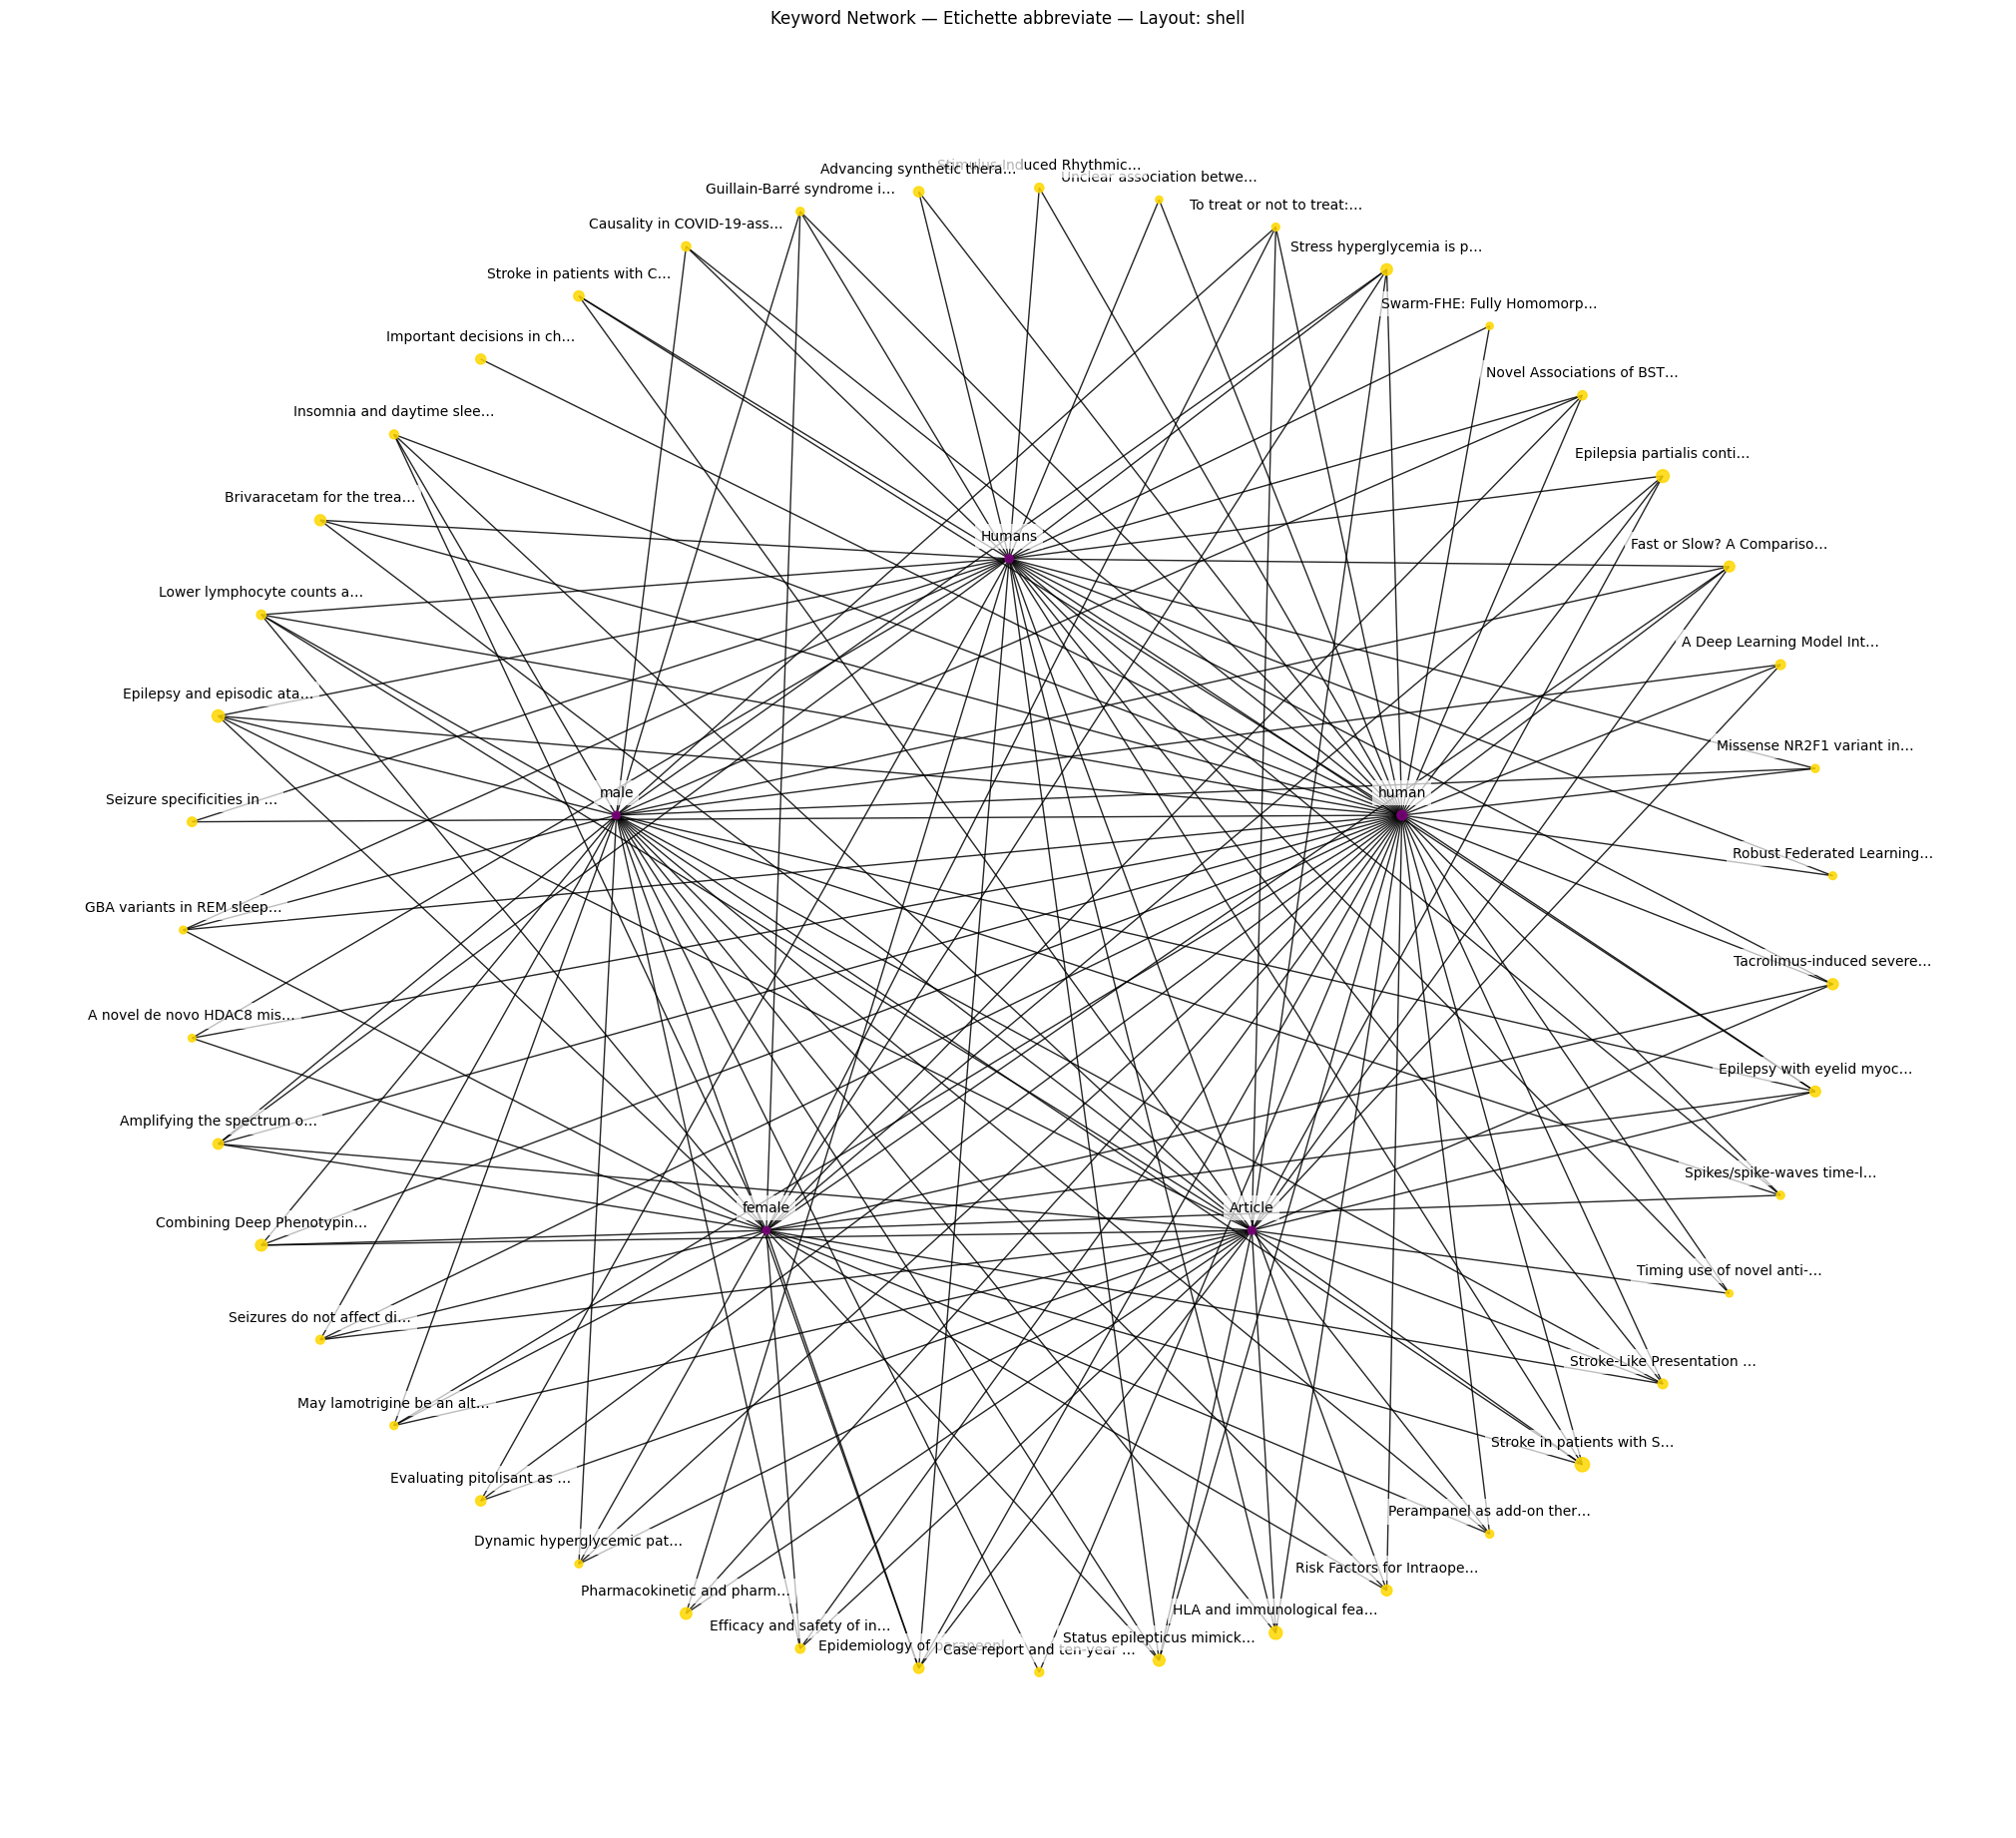

In [ ]:
LAYOUT = "shell" ## FORSE CI PIACE
G_kw_filt = G_kw_filt.subgraph([n for n in G_kw_filt if G_kw_filt.degree(n) > 0]).copy()
pos_kw = compute_layout(G_kw_filt, layout=LAYOUT)

plt.figure(figsize=(20,18))

sizes = [cent_kw[n] * 2500 for n in G_kw_filt.nodes()]
colors = [
    "gold" if G_kw_filt.nodes[n]["type"]=="article" else "purple"
    for n in G_kw_filt.nodes()
]

nx.draw(
    G_kw_filt, pos_kw,
    node_size=sizes,
    node_color=colors,
    with_labels=False,
    alpha=0.85
)

# --- etichette meno complete ---
def shorten_label(text, maxlen=25):
    return text if len(text) <= maxlen else text[:maxlen] + "…"

labels_all = {n: shorten_label(n) for n in G_kw_filt.nodes()}

offset_pos = {n: (x, y+0.03) for n, (x, y) in pos_kw.items()}

nx.draw_networkx_labels(
    G_kw_filt, offset_pos, labels_all,
    font_size=10,
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)
)

plt.title(f"Keyword Network — Etichette abbreviate — Layout: {LAYOUT}")
plt.show()

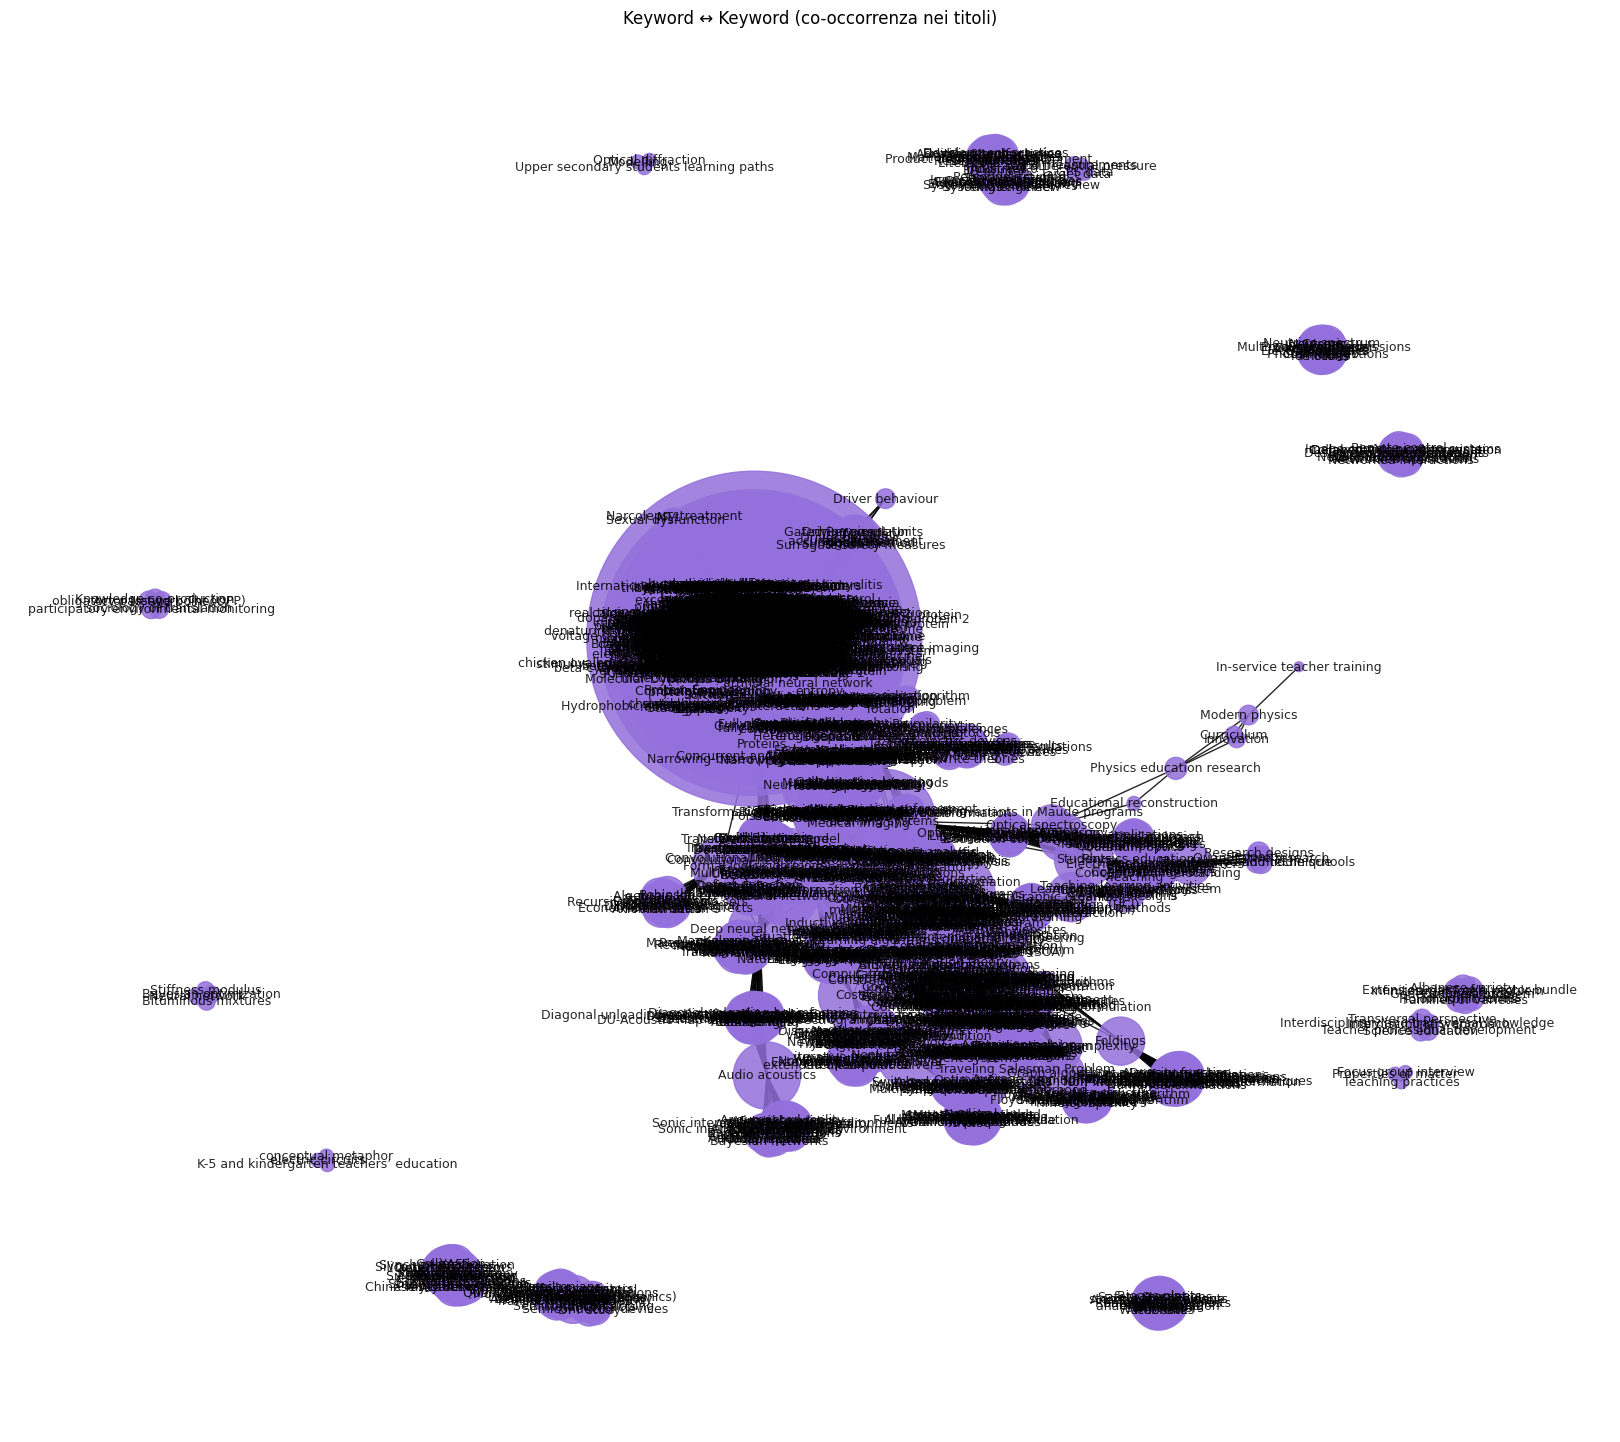

In [52]:
from networkx.algorithms import bipartite

# 1. Costruisci il grafo bipartito articolo ↔ keyword
G_kw = nx.Graph()

for _, row in df.iterrows():
    article = row["Title"]
    keywords = row["all_keywords"]

    for kw in keywords:
        G_kw.add_node(article, type="article")
        G_kw.add_node(kw, type="keyword")
        G_kw.add_edge(article, kw)

# 2. Estrai solo le keyword
keywords = [n for n in G_kw.nodes() if G_kw.nodes[n]["type"] == "keyword"]

# 3. Proiezione: keyword ↔ keyword
G_kw_proj = bipartite.weighted_projected_graph(G_kw, keywords)

# 4. Filtraggio per grado minimo
G_kw_proj_filt = G_kw_proj.subgraph([n for n in G_kw_proj if G_kw_proj.degree(n) >= 1]).copy()

# 5. Layout + visualizzazione
pos = nx.spring_layout(G_kw_proj_filt, k=0.8, iterations=200)

plt.figure(figsize=(16,14))
nx.draw(
    G_kw_proj_filt, pos,
    node_size=[G_kw_proj_filt.degree(n)*50 for n in G_kw_proj_filt],
    node_color="mediumpurple",
    with_labels=True,
    font_size=9,
    alpha=0.85
)

plt.title("Keyword ↔ Keyword (co-occorrenza nei titoli)")
plt.show()